In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import linalg as la
from pykalman import KalmanFilter as K_F
#from filterpy.kalman import KalmanFilter
import os
from scipy.linalg import inv, norm

In [2]:
df = pd.read_csv("FedCycleData071012.csv")

In [3]:
df["ClientID"].unique()

array(['nfp8122', 'nfp8114', 'nfp8109', 'nfp8107', 'nfp8106', 'nfp8024',
       'nfp8020', 'nfp8026', 'nfp8030', 'nfp8031', 'nfp8032', 'nfp8034',
       'nfp8036', 'nfp8040', 'nfp8041', 'nfp8042', 'nfp8043', 'nfp8045',
       'nfp8046', 'nfp8047', 'nfp8049', 'nfp8050', 'nfp8051', 'nfp8057',
       'nfp8058', 'nfp8060', 'nfp8062', 'nfp8063', 'nfp8064', 'nfp8066',
       'nfp8068', 'nfp8069', 'nfp8072', 'nfp8073', 'nfp8074', 'nfp8076',
       'nfp8079', 'nfp8080', 'nfp8083', 'nfp8085', 'nfp8087', 'nfp8091',
       'nfp8094', 'nfp8099', 'nfp8100', 'nfp8101', 'nfp8102', 'nfp8110',
       'nfp8113', 'nfp8116', 'nfp8123', 'nfp8124', 'nfp8129', 'nfp8131',
       'nfp8133', 'nfp8137', 'nfp8140', 'nfp8143', 'nfp8144', 'nfp8149',
       'nfp8150', 'nfp8152', 'nfp8154', 'nfp8155', 'nfp8159', 'nfp8161',
       'nfp8164', 'nfp8165', 'nfp8168', 'nfp8172', 'nfp8173', 'nfp8174',
       'nfp8176', 'nfp8177', 'nfp8178', 'nfp8179', 'nfp8184', 'nfp8186',
       'nfp8187', 'nfp8188', 'nfp8189', 'nfp8190', 

In [4]:
data = df.loc[df["ClientID"] == 'nfp8122']



In [5]:
y = np.array(data["LengthofCycle"])

In [6]:

y = np.array(data["LengthofCycle"])
train = y[:40]
test = y[-5:]


In [7]:
def SBR(N, k, p, N_states, train):
    Yf = np.vstack([train[i:i+N] for i in range(k,2*k)])
    Yp = np.vstack([train[i: i + N] for i in range(k-1,-1,-1)])

    sigma_pp = 1/N*Yp@Yp.T
    sigma_ff = 1/N*Yf@Yf.T
    sigma_fp = 1/N * Yf@Yp.T
    sigma_pf = 1/N * Yp@Yf.T
    
    L = la.sqrtm(sigma_ff)
    M = la.sqrtm(sigma_pp)
    
    
    S = la.inv(L)@sigma_fp @ la.inv(M).T
    U,s,Vh = la.svd(S)

    U = U[:,:N_states]
    s = np.diag(s[:N_states])    
    Vh = Vh[:N_states] 
    
    O_k = L@U@np.sqrt(s)
    C_k = np.sqrt(s)@Vh@(M.T)
    
    Ohk = O_k[p:k*p,:]
    Olk = O_k[:(k-1)*p,:]

    A = np.linalg.pinv(Ohk)@Olk

    C = O_k[:p,:]
    ChT = C_k[:,:p]

    R = np.cov(y) - C@s@(C.T)
    K = (ChT - A@s@(C.T))@np.linalg.inv(np.cov(y) - C@s@(C.T))
    
    
    return A, C, R, K


In [8]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.

        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u

    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        #initialize to populate with obs and states
        obs = np.zeros((self.H.shape[0],N))
        states = np.zeros((len(x0),N))
        states[:,0] = x0
        m,N = obs.shape
        for i in range(N-1):
            # F *x_i - 1 + u[i] + noise
            states[:,i+1] = self.F@states[:,i] +self.u + np.random.multivariate_normal(np.zeros_like(x0),self.Q)
            # transition from X to Z
            obs[:,i] = self.H@states[:,i] + np.random.multivariate_normal(np.zeros(m),self.R)
        #still need the last observation
        obs[:,-1] = self.H@states[:,-1] + np.random.multivariate_normal(np.zeros(m),self.R)

        return states, obs

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        norms: list of floats of length N
            Gives the norm of the error matrix for each estimate.
        """
        n = len(x0)
        I = np.eye(n)
        #iinitialize
        
        
        if z.ndim == 1:
            N = len(z)
            out = np.zeros((n,N))
            out[:,0] = x0
            for i in range(N-1):
                #Predict
                
                xk_p = self.F@out[:,i] + self.u

                pk_p = self.F@ P0 @(self.F.T) + self.Q

                #update
                yk = z[i+1] - self.H@xk_p

                Sk = self.H@pk_p@(self.H.T) + self.R

                Kk = pk_p@(self.H.T)@inv(Sk)

                out[:,i+1] = xk_p + Kk@yk

                P0 = (I - Kk@self.H)@pk_p #overwrite P0
                
        else:
            m,N = z.shape
            out = np.zeros((n,N))
            out[:,0] = x0

            for i in range(N-1):
                #Predict
                xk_p = self.F@out[:,i] + self.u

                pk_p = self.F@ P0 @(self.F.T) + self.Q

                #update
                yk = z[:,i+1] - self.H@xk_p

                Sk = self.H@pk_p@(self.H.T) + self.R

                Kk = pk_p@(self.H.T)@inv(Sk)

                out[:,i+1] = xk_p + Kk@yk

                P0 = (I - Kk@self.H)@pk_p #overwrite P0


        return out



    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        #initialize
        n = len(x)
        out = np.zeros((n,k))
        #first one based off of given observation
        out[:,0] = self.F@x + self.u
        for i in range(k-1): #fill rest with equation
            out[:,i+1] = self.F@out[:,i] + self.u

        return out



    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.

        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        n = len(x)
        iF = inv(self.F) #calling it a lot so calculate once
        out = np.zeros((n,k))
        out[:,-1] = iF@(x - self.u) #make sure to go backward
        for i in range(k-1):
            out[:,-1-(i+1)] = iF@(out[:,-1-i] - self.u) # going backward

        return out

In [9]:
A,C,R,K = SBR(5,10,1,6,train)


A = np.real(A)
C = np.real(C)

F = A
G = np.eye(A.shape[0])
Q = np.eye(A.shape[0])
H = C
R = R
u = np.zeros(6)
x0hat = np.array(np.ones(6))

P = .1*np.eye(Q.shape[0]) 

In [10]:
KF = KalmanFilter(F,Q,H,R,u)

In [11]:
X_hat = KF.estimate(x0hat,P,train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:101: ComplexWarning: Casting complex values to real discards the imaginary part


In [12]:
final_state = X_hat[:,-1]
predict = KF.predict(final_state,5)

In [13]:
pred = np.real(H@predict)[0]

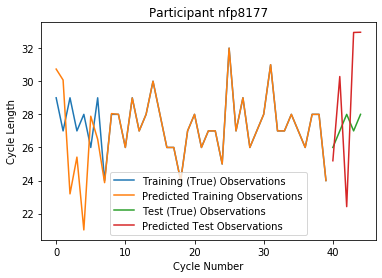

In [14]:

x1 = np.arange(0,40)
x2 = np.arange(40,45)
plt.figure(figsize = (6,4))
plt.plot(x1,train, label = "Training (True) Observations")
plt.plot(x1,np.real(H@X_hat)[0], label = "Predicted Training Observations")
plt.plot(x2,test, label = "Test (True) Observations")
plt.plot(x2, pred, label = "Predicted Test Observations")
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Cycle Length")
plt.title("Participant nfp8177")
plt.savefig("Kalman_nfp8177.png")

In [15]:
#run estimation for state space filter
kf = K_F(transition_matrices = A, observation_matrices = C,em_vars = ['initial_state_mean', 'initial_state_covariance'])
measurements = train  
kf = kf.em(measurements, n_iter=5)
filtered_state_means, filtered_state_covariances = kf.filter(measurements)


In [16]:
#run prediction with Kalman Filter class
predict = KF.predict(filtered_state_means[-1],5)
pred = np.real(H@predict)[0]

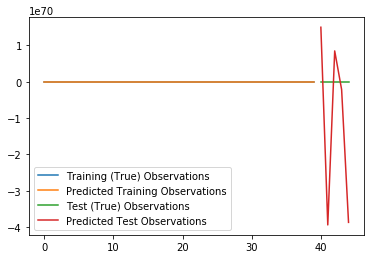

In [17]:
x1 = np.arange(0,40)
x2 = np.arange(40,45)
plt.plot(x1,train, label = "Training (True) Observations")
plt.plot(x1,np.real(H@X_hat)[0], label = "Predicted Training Observations")
plt.plot(x2,test, label = "Test (True) Observations")
plt.plot(x2, pred, label = "Predicted Test Observations")
plt.legend()